# Overall price 

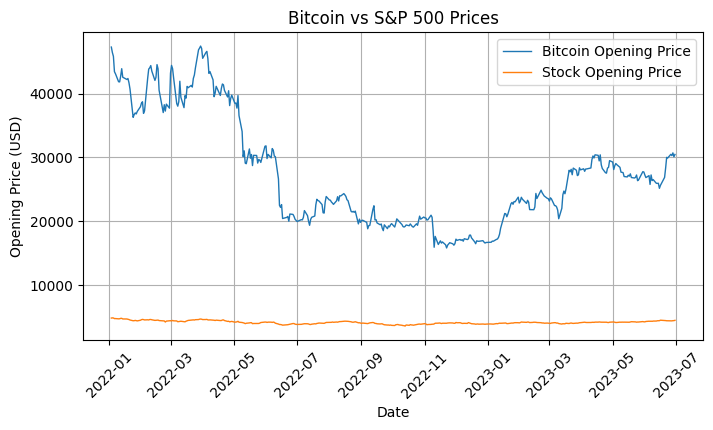

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
#from tensorflow.keras import Input

prices = pd.read_csv('./Processed/combined_prices.csv')

prices['Date'] = pd.to_datetime(prices['Date'])
prices = prices.sort_values('Date')
prices.set_index('Date', inplace=True)


plt.figure(figsize=(8, 4)) 
plt.plot(prices.index, prices['Open_B'], label='Bitcoin Opening Price', linewidth=1)
plt.plot(prices.index, prices['Open_S'], label='Stock Opening Price', linewidth=1)

plt.title('Bitcoin vs S&P 500 Prices')
plt.xlabel('Date')
plt.ylabel('Opening Price (USD)')

plt.xticks(rotation=45)

plt.grid(True)

plt.legend()  
plt.show()

LSTM.dropout = 0.0

Epoch 1/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1361 - val_loss: 0.0604
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0850 - val_loss: 0.0140
Epoch 3/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0196 - val_loss: 0.0027
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0126 - val_loss: 0.0064
Epoch 5/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0118 - val_loss: 0.0034
Epoch 6/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0081 - val_loss: 0.0031
Epoch 7/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 0.0073
Epoch 8/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - val_loss: 0.0065
Epoch 9/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 - val_loss: 0.0096
Epoch 10/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 0.0061
Epoch 11/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058 - val_loss: 0.0074
Epoch 12/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 13/40


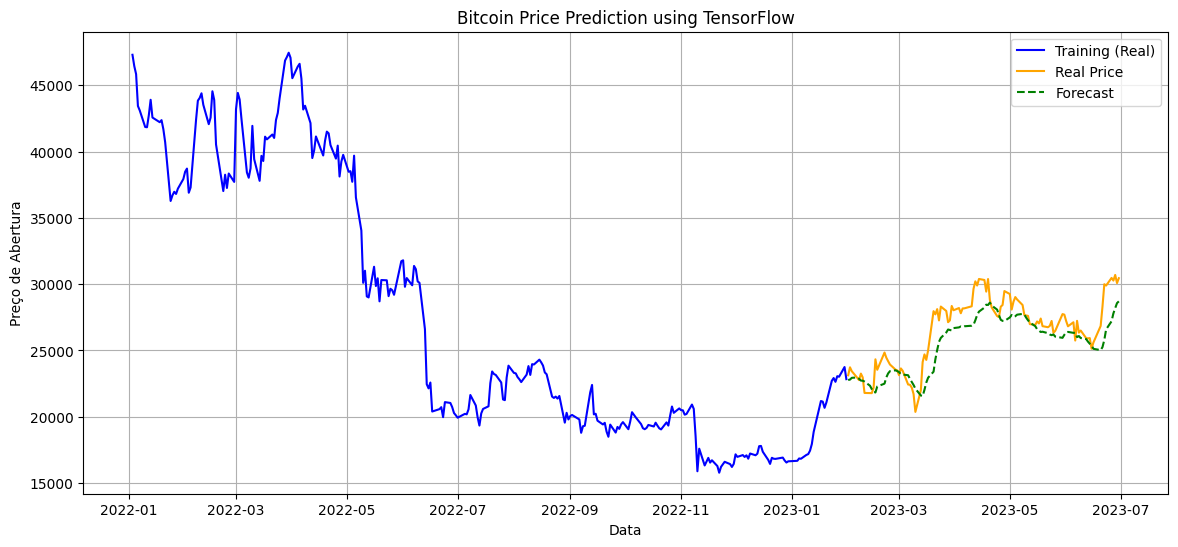

MAE: 1180.10
MSE: 2392424.20
RMSE: 1546.75
R² Score: 0.64


In [90]:
prices.reset_index(inplace=True)
prices = prices[['Date', 'Open_B']].dropna()

scaler = MinMaxScaler()
scaled = scaler.fit_transform(prices[['Open_B']])
prices['Scaled'] = scaled

def create_sequences(data, window=30):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(prices['Scaled'].values, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

test = []

model = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(64, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


plt.figure(figsize=(14, 6))
plt.plot(prices['Date'].iloc[:len(X_train) + window_size],
         scaler.inverse_transform(prices['Scaled'].values[:len(X_train) + window_size].reshape(-1, 1)), 
         label='Training (Real)', color='blue'
         )
plt.plot(prices['Date'].iloc[-len(y_test_inv):], y_test_inv.ravel(), label='Real Price', color='orange')
plt.plot(prices['Date'].iloc[-len(y_pred_inv):], y_pred_inv.ravel(), label='Forecast', color='green', linestyle='dashed')
plt.title('Bitcoin Price Prediction using TensorFlow')
plt.xlabel('Data')
plt.ylabel('Preço de Abertura')
plt.legend()
plt.grid()
plt.show()
prices.tail


mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")



Epoch 1/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.3008 - val_loss: 0.2741
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1860 - val_loss: 0.0663
Epoch 3/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0840 - val_loss: 0.0496
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0787 - val_loss: 0.0871
Epoch 5/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0725 - val_loss: 0.0426
Epoch 6/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0677 - val_loss: 0.0443
Epoch 7/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0651 - val_loss: 0.0604
Epoch 8/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0667 - val_loss: 0.0460
Epoch 9/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0654 - val_loss: 0.0421
Epoch 10/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0673 - val_loss: 0.0592
Epoch 11/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0660 - val_loss: 0.0393
Epoch 12/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0568 - val_loss: 0.0604
Epoch 13/40


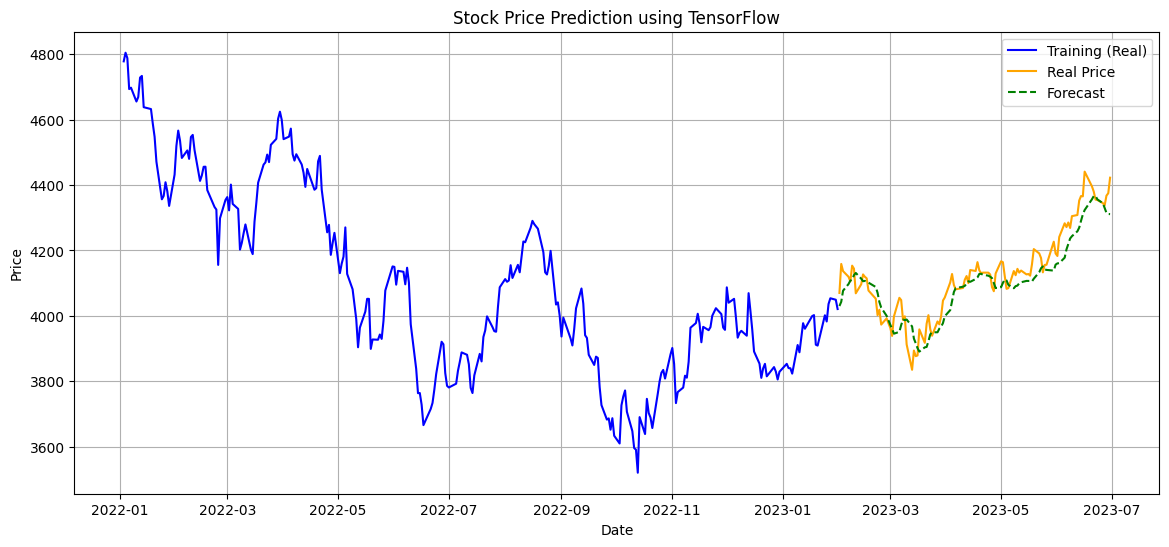

MAE: 39.92
MSE: 2539.75
RMSE: 50.40
R² Score: 0.85


In [91]:
df = pd.read_csv('./Processed/combined_prices.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df[['Date', 'Open_S']].dropna()

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['Open_S']])
df['Scaled'] = scaled

def create_sequences(data, window=30):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(df['Scaled'].values, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

model = Sequential([
    Input(shape=(window_size, 1)), 
    LSTM(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mae')
model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


plt.figure(figsize=(14, 6))
plt.plot(df['Date'].iloc[:len(X_train) + window_size],
         scaler.inverse_transform(df['Scaled'].values[:len(X_train) + window_size].reshape(-1, 1)), 
         label='Training (Real)', color='blue'
         )
plt.plot(df['Date'].iloc[-len(y_test_inv):], y_test_inv.ravel(), label='Real Price', color='orange')
plt.plot(df['Date'].iloc[-len(y_pred_inv):], y_pred_inv.ravel(), label='Forecast', color='green', linestyle='dashed')
plt.title('Stock Price Prediction using TensorFlow')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

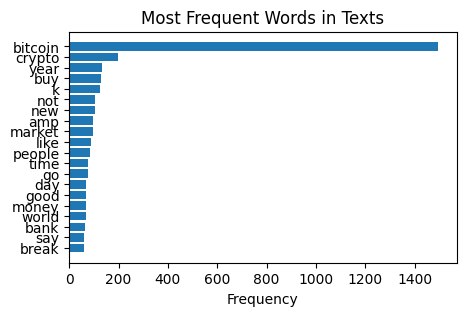

<bound method NDFrame.tail of         token       date  reply_count  like_count  retweet_count  quote_count  \
0     bitcoin 2022-01-01           49         494            133           15   
1     bitcoin 2022-01-01           18         306             30            9   
2     bitcoin 2022-01-01           77         188             28            0   
3     bitcoin 2022-01-02          201        2743            750           22   
4     bitcoin 2022-01-02           99         946            164           10   
...       ...        ...          ...         ...            ...          ...   
1609  bitcoin 2023-06-21           38        1169            141            6   
1610  bitcoin 2023-06-21          184        3056            567           32   
1611  bitcoin 2023-06-22          241        5397           1419           60   
1612  bitcoin 2023-06-22          148        2503            512           13   
1613  bitcoin 2023-06-22          106         347             35            0  

In [92]:
from collections import Counter

visu_words = pd.read_pickle('visu_words.pkl')

word_counter = Counter()

for tokens in visu_words['text']:
    word_counter.update(tokens)

words, counts = zip(*word_counter.most_common(20))

plt.figure(figsize=(5, 3))
plt.barh(words[::-1], counts[::-1])
plt.xlabel('Frequency')
plt.title('Most Frequent Words in Texts')
plt.show()
visu_words.tail
